# TFG

En este notebook, encontrará el código correspondiente al trabajo de fin de grado adjunto en el siguiente github https://github.com/Aran00b/TFG. Para una mejor comprensión del código, se recomienda leer el documento del trabajo. Para cualquier consulta o sugerencia, no dude en ponerse en contacto a través del correo electrónico: adriancandilsalas94@gmail.com.

Es recomendable utilizar GoogleColab pro para ejecutar el código debido a que la versión gratuita no soporta los entrenamientos y se desconecta en la mayoría de las ocasiones. Durante el desarrollo hemos utilizado el entorno L4 con la opción de alta capacidad de RAM.

También se recomienda enlazar GoogleColab con GoogleDrive para importar los conjuntos de datos de manera eficiente.

El dataset utilizado se encuentra en https://zenodo.org/records/7074958

-------------------------------------------------------------------------------
In this notebook, you will find the code corresponding to the final degree project attached in the following GitHub repository: https://github.com/Aran00b/TFG. For a better understanding of the code, it is recommended to read the project document. For any questions or suggestions, please do not hesitate to contact me via email: adriancandilsalas94@gmail.com.

It is recommended to use Google Colab Pro to run the code because the free version does not support the training processes and disconnects most of the time. During development, we used the L4 environment with the high RAM capacity option.

It is also recommended to link Google Colab with Google Drive to import datasets efficiently.

The dataset used can be found at https://zenodo.org/records/7074958

## 0. IMPORTS

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten,
    Conv2DTranspose, Reshape, Embedding, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

import zipfile
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from google.colab import files

## 1. DATA LOAD

### 1.1 RAW DATA

In [ ]:
extract_path = '/content/'

In [ ]:
#Ruta a las imágenes
data = '/content/drive/MyDrive/Corridors v2.0.zip'

In [ ]:
#Ruta a los pesos de los modelos ya entrenados
weighs = '/content/drive/MyDrive/autoencoder_weights_my_version_1st_train.zip'

In [ ]:
with zipfile.ZipFile(data, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
with zipfile.ZipFile(weighs, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### 1.2 RESIZE AND LOAD INTO ARRAY

In [ ]:
# Define el path a la carpeta donde están las imágenes
training_autoencoder_folder_path = '/content/s1_frames/training_set'

# Obtiene una lista de los nombres de las imágenes
image_files = os.listdir(training_autoencoder_folder_path)

# Carga las imágenes en una lista
image_list = []
for filename in image_files:
    img = Image.open(os.path.join(training_autoencoder_folder_path, filename))
    img = img.resize((64, 64))
    img = np.array(img)
    image_list.append(img)

# Convierte la lista en un array que puede procesar el autoencoder
X_train_autoencoder = np.array(image_list)

print(X_train_autoencoder.shape)

(56066, 64, 64, 3)


In [ ]:
training_autoencoder_folder_path = '/content/s1_frames/validation_set'

image_files = os.listdir(training_autoencoder_folder_path)

image_list = []
for filename in image_files:
    img = Image.open(os.path.join(training_autoencoder_folder_path, filename))
    img = img.resize((64, 64))
    img = np.array(img)
    image_list.append(img)

X_validation_autoencoder = np.array(image_list)

print(X_validation_autoencoder.shape)

(2471, 64, 64, 3)


In [ ]:
training_autoencoder_folder_path = '/content/s1_frames/test_set'

image_files = os.listdir(training_autoencoder_folder_path)

image_list = []
for filename in image_files:
    img = Image.open(os.path.join(training_autoencoder_folder_path, filename))
    img = img.resize((64, 64))
    img = np.array(img)
    image_list.append(img)

X_test_autoencoder = np.array(image_list)

print(X_test_autoencoder.shape)


(56100, 64, 64, 3)


In [ ]:
training_autoencoder_folder_path = '/content/s1_frames/outliers_set'

image_files = os.listdir(training_autoencoder_folder_path)

image_list = []
for filename in image_files:
    img = Image.open(os.path.join(training_autoencoder_folder_path, filename))
    img = img.resize((64, 64))
    img = np.array(img)
    image_list.append(img)

X_train_autoencoder2 = np.array(image_list)

print(X_train_autoencoder2.shape)

(18201, 64, 64, 3)


# 2. AUTOENCODER

## 2.1 MODEL

### Version 1

In [ ]:
# Encoder
encoder_input = tf.keras.Input(shape=(64, 64, 3))

x = layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding='same',name="conv1")(encoder_input)
x = MaxPooling2D((2, 2), padding='same',name="pool1")(x)

x = layers.Conv2D(256, (3, 3), activation=tf.nn.leaky_relu, padding='same',name="conv2")(x)
x = MaxPooling2D((2, 2), padding='same',name="pool2")(x)

x = layers.Conv2D(512, (3, 3), activation=tf.nn.leaky_relu, padding='same',name="conv3")(x)
x = MaxPooling2D((2, 2), padding='same',name="pool3")(x)

x = layers.Conv2D(1024, (3, 3), activation=tf.nn.leaky_relu, padding='same',name="conv4")(x)
x = MaxPooling2D((2, 2), padding='same',name="pool4")(x)

x = layers.Flatten()(x)
encoded = layers.Dense(128, activation="linear", name="dense_layer")(x)
encoder = Model(encoder_input, encoded, name='encoder')


# Decoder
decoder_input = layers.Input(shape=(128,))

x = layers.Dense(16384, activation=tf.nn.leaky_relu)(decoder_input)
x = layers.Reshape((8, 8, 256))(x)

x = layers.Conv2DTranspose(512, (3, 3), padding='same', activation=tf.nn.leaky_relu,name="conv5")(x)
x = UpSampling2D((2, 2),name="up1")(x)

x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation=tf.nn.leaky_relu,name="conv6")(x)
x = UpSampling2D((2, 2),name="up2")(x)

x = layers.Conv2DTranspose(128, (3, 3),  padding='same', activation=tf.nn.leaky_relu,name="conv7")(x)
x = UpSampling2D((2, 2),name="up3")(x)

decoded = layers.Conv2DTranspose(3, (3, 3), activation='linear', padding='same', name="final_conv")(x)


decoder = Model(decoder_input, decoded, name='decoder')

# Autoencoder model
autoencoder_input = tf.keras.Input(shape=(64, 64, 3))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, decoded_img, name='autoencoder')

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')  # Using mean squared error as the loss function







In [ ]:
autoencoder.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

### Version 2

In [ ]:
# ENCODER
encoder = keras.Sequential(name='encoder')

encoder.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", name='input', input_shape=(64, 64, 3)))

encoder.add(keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", name='conv1'))

encoder.add(keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", name='conv2'))

encoder.add(keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", name='conv3'))

encoder.add(keras.layers.Flatten(name='flatten'))
encoder.add(keras.layers.Dense(units=128, activation='linear', name='dense'))
encoder.add(keras.layers.Embedding(input_dim=128, output_dim=128, embeddings_initializer='glorot_uniform', embeddings_regularizer='L1L2'))

# DECODER
decoder = keras.Sequential(name='decoder')

decoder.add(keras.layers.Input(shape=(128, 128), name='input'))
decoder.add(keras.layers.Reshape((4, 4, 1024)))

decoder.add(keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='leaky_relu', padding='same'))

decoder.add(keras.layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2),  activation="leaky_relu", padding='same', name='deconvconv1'))

decoder.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", padding='same', name='deconvconv2'))

decoder.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2),  activation="leaky_relu", padding='same', name='deconvconv3'))

decoder.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), activation="linear", padding='same', name='output'))

# AUTOENCODER
autoencoder_input = keras.layers.Input(shape=(64, 64, 3), name='autoencoder_input')
encoded_repr = encoder(autoencoder_input)
decoded_repr = decoder(encoded_repr)

autoencoder = keras.models.Model(inputs=autoencoder_input, outputs=decoded_repr, name='autoencoder')

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')

In [ ]:
autoencoder.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

### Version 3

In [ ]:
# ENCODER
encoder = keras.Sequential(name='encoder')

encoder.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2),
                                activation="leaky_relu", name='input', input_shape=(64, 64, 3)))

encoder.add(keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2),
                                activation="leaky_relu", name='conv1'))

encoder.add(keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(2, 2),
                                activation="leaky_relu", name='conv2'))

encoder.add(keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(2, 2),
                                activation="leaky_relu", name='conv3',
                                kernel_regularizer=regularizers.l2(0.01)))

encoder.add(keras.layers.Flatten(name='flatten'))
encoder.add(keras.layers.Dense(units=128, activation='linear', name='dense',
                               kernel_regularizer=regularizers.l2(0.01)))
encoder.add(keras.layers.Embedding(input_dim=128, output_dim=128, embeddings_initializer='glorot_uniform', embeddings_regularizer='L1L2'))

# DECODER
decoder = keras.Sequential(name='decoder')

decoder.add(keras.layers.Input(shape=(128, 128), name='input'))
decoder.add(keras.layers.Reshape((4, 4, 1024)))

decoder.add(keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='leaky_relu', padding='same'))

decoder.add(keras.layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2),
                                         activation="leaky_relu", padding='same', name='deconvconv1',
                                         kernel_regularizer=regularizers.l2(0.01)))

decoder.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2),
                                         activation="leaky_relu", padding='same', name='deconvconv2'))

decoder.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2),
                                         activation="leaky_relu", padding='same', name='deconvconv3'))

decoder.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2),
                                         activation="linear", padding='same', name='output'))

# AUTOENCODER
autoencoder_input = keras.layers.Input(shape=(64, 64, 3), name='autoencoder_input')
encoded_repr = encoder(autoencoder_input)
decoded_repr = decoder(encoded_repr)
autoencoder = keras.models.Model(inputs=autoencoder_input, outputs=decoded_repr, name='autoencoder')
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')

In [ ]:
autoencoder.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

### Version 4

In [1]:
# ENCODER
encoder = models.Sequential(name='encoder')
encoder.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), input_shape=(64, 64, 3), name='input'))
encoder.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), name='conv1'))
encoder.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), name='conv2'))
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(units=128, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), name='dense'))

# DECODER
decoder = models.Sequential(name='decoder')
decoder.add(layers.Input(shape=(128,), name='input'))
decoder.add(layers.Dense(4*4*256, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), name='dense'))
decoder.add(layers.Reshape((4, 4, 256)))
decoder.add(layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), padding='same', name='deconvconv1'))
decoder.add(layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), padding='same', name='deconvconv2'))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), activation="leaky_relu", kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), padding='same', name='deconvconv3'))
decoder.add(layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), activation="linear", kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01), padding='same', name='output'))

# AUTOENCODER
autoencoder_input = layers.Input(shape=(64, 64, 3), name='autoencoder_input')
encoded_repr = encoder(autoencoder_input)
decoded_repr = decoder(encoded_repr)

autoencoder = models.Model(inputs=autoencoder_input, outputs=decoded_repr, name='autoencoder')
opt = Adam(learning_rate=0.001, clipnorm=1.0)
autoencoder.compile(optimizer=opt, loss='mse')



In [ ]:
autoencoder.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

### Version 5

In [ ]:
encoder = keras.Sequential(name='encoder')

encoder.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3),strides=(2, 2),padding='same',activation='leaky_relu',name='conv1',input_shape=(64, 64, 3)))

encoder.add(keras.layers.Conv2D(filters=64,kernel_size=(3, 3),strides=(2, 2),padding='same',activation='leaky_relu',name='conv2',
))

encoder.add(keras.layers.Conv2D(filters=128,kernel_size=(3, 3),strides=(2, 2),padding='same',activation='leaky_relu',name='conv3',
))

encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(units=128, activation='linear', kernel_initializer='glorot_uniform', name='dense'))

decoder = keras.Sequential(name='decoder')
decoder.add(layers.Dense(units=8 * 8 * 128, activation='linear', kernel_initializer='glorot_uniform', name='dense2'))
decoder.add(layers.Reshape((8, 8, 128), name='reshape'))

decoder.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3),strides=(2, 2), padding='same',activation='leaky_relu', name='conv5',
))

decoder.add(keras.layers.Conv2DTranspose( filters=32, kernel_size=(3, 3),strides=(2, 2),padding='same',activation='leaky_relu',name='conv6',
))

decoder.add(keras.layers.Conv2DTranspose(filters=3,kernel_size=(3, 3),strides=(2, 2),padding='same',activation='linear',name='output'
))

autoencoder_input = layers.Input(shape=(64, 64, 3), name='autoencoder_input')
encoded_repr = encoder(autoencoder_input)
decoded_repr = decoder(encoded_repr)

autoencoder = models.Model(inputs=autoencoder_input, outputs=decoded_repr, name='autoencoder')
opt = Adam(learning_rate=0.001, clipnorm=1.0)
autoencoder.compile(optimizer=opt, loss='mse')


In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 64, 64, 3)]       0         
 yer)                                                            
                                                                 
 encoder (Sequential)        (None, 128)               1141952   
                                                                 
 decoder (Sequential)        (None, 64, 64, 3)         1149891   
                                                                 
Total params: 2291843 (8.74 MB)
Trainable params: 2291843 (8.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
Total params: 1141952 (4.36 MB)
Trainable params: 1141952 (4.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense2 (Dense)              (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv5 (Conv2DTranspose)     (None, 16, 16, 64)        73792     
                                                                 
 conv6 (Conv2DTranspose)     (None, 32, 32, 32)        18464     
                                                                 
 output (Conv2DTranspose)    (None, 64, 64, 3)         867       
                                                                 
Total params: 1149891 (4.39 MB)
Trainable params: 1149891 (4.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Save autoencoder

In [ ]:
#Guarda el modelo entero
autoencoder.save('autoencoder')

In [ ]:

folder_to_zip = '/content/autoencoder'

zip_filename = 'autoencoder.zip'

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_to_zip))

files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Guarda solo los pesos del modelo
model.save_weights('autoencoder_weights_my_version_1st_train.h5')

## Load autoencoder

In [ ]:
ruta_autoencoder = '/content/drive/MyDrive/autoencoder(1).zip'

In [ ]:
with zipfile.ZipFile(ruta_autoencoder, 'r') as zip_ref:
    zip_ref.extractall('autoencoder')

In [ ]:
#Con esta opción cargamos el modelo directamente
autoencoder = tf.keras.models.load_model('/content/autoencoder')

In [ ]:
#Con esta opción cargamos solo los pesos del modelo
file_path = 'autoencoder_weights_my_version_1st_train.h5'
zip_path = 'autoencoder_weights_my_version_1st_train.zip'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(file_path, arcname='autoencoder_weights_my_version_1st_train.h5')

print(f'File compressed and saved as {zip_path}')


## 2.2.1 TRAINING

### 2.2.1.1 Data augmentation

In [ ]:
images = X_train_autoencoder
data_format = 'channels_last'

datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    brightness_range=[0.6, 1.7],
    zoom_range=[0.5, 1.0],
    fill_mode='nearest'
)


augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False).next()

In [ ]:
all_data = np.concatenate((normales, modificadas), axis=0)
all2 = np.array(all_data)
all3 = np.random.permutation(all2)

### 2.2.1.2 Cross validation

In [ ]:
# Parámetros de cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

model = autoencoder

mse_scores = []
i = 0
for train_index, val_index in kf.split(X_train_autoencoder):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7)

    X_train_fold, X_val_fold = X_train_autoencoder[train_index], X_train_autoencoder[val_index]
    # Entrenar el modelo
    model.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, X_val_fold), verbose=1, callbacks=[early_stopping, reduce_lr])

    # Evaluar el modelo
    mse_loss = model.evaluate(X_val_fold, X_val_fold, verbose=0)
    mse_scores.append(mse_loss)
    i += 1
    print(f'Vamos por el split {i}')

print(f"Mean MSE over {n_splits} folds: {np.mean(mse_scores)}")


Epoch 1/10
1577/1577 [==============================] - 14s 7ms/step - loss: 492.1843 - val_loss: 202.8269 - lr: 0.0010
Epoch 2/10
1577/1577 [==============================] - 10s 7ms/step - loss: 158.3739 - val_loss: 113.6171 - lr: 0.0010
Epoch 3/10
1577/1577 [==============================] - 10s 6ms/step - loss: 113.5494 - val_loss: 109.1907 - lr: 0.0010
Epoch 4/10
1577/1577 [==============================] - 10s 7ms/step - loss: 94.4402 - val_loss: 83.0168 - lr: 0.0010
Epoch 5/10
1577/1577 [==============================] - 10s 7ms/step - loss: 82.5878 - val_loss: 71.8824 - lr: 0.0010
Epoch 6/10
1577/1577 [==============================] - 10s 6ms/step - loss: 66.6722 - val_loss: 61.3224 - lr: 0.0010
Epoch 7/10
1577/1577 [==============================] - 10s 6ms/step - loss: 59.6419 - val_loss: 57.9800 - lr: 0.0010
Epoch 8/10
1577/1577 [==============================] - 10s 6ms/step - loss: 55.6177 - val_loss: 54.2656 - lr: 0.0010
Epoch 9/10
1577/1577 [============================

### 2.2.1.3 Normalization of the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_autoencoder.reshape(-1, X_train_autoencoder.shape[-1])).reshape(X_train_autoencoder.shape)


### 2.2.2.1 Training


#### Callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-6)

#### Training

In [ ]:
# Entrenar el modelo
autoencoder.fit(
    X_train_autoencoder, X_train_autoencoder,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/100
1402/1402 [==============================] - 17s 7ms/step - loss: 544.6313 - val_loss: 211.9201 - lr: 0.0010
Epoch 2/100
1402/1402 [==============================] - 9s 7ms/step - loss: 176.5848 - val_loss: 130.6201 - lr: 0.0010
Epoch 3/100
1402/1402 [==============================] - 10s 7ms/step - loss: 117.3998 - val_loss: 114.2766 - lr: 0.0010
Epoch 4/100
1402/1402 [==============================] - 10s 7ms/step - loss: 87.8558 - val_loss: 75.0340 - lr: 0.0010
Epoch 5/100
1402/1402 [==============================] - 10s 7ms/step - loss: 70.2324 - val_loss: 66.3647 - lr: 0.0010
Epoch 6/100
1402/1402 [==============================] - 10s 7ms/step - loss: 63.3616 - val_loss: 61.2612 - lr: 0.0010
Epoch 7/100
1402/1402 [==============================] - 9s 7ms/step - loss: 58.8870 - val_loss: 57.3208 - lr: 0.0010
Epoch 8/100
1402/1402 [==============================] - 9s 7ms/step - loss: 55.4950 - val_loss: 54.3667 - lr: 0.0010
Epoch 9/100
1402/1402 [======================

## 2.2.2 EXAMPLE


In [ ]:
encoder_model = autoencoder.get_layer('encoder')
decoder_model = autoencoder.get_layer('decoder')

### Example 1

In [ ]:
img = Image.open('/content/s1_frames/training_set/001000_512_512.jpg')

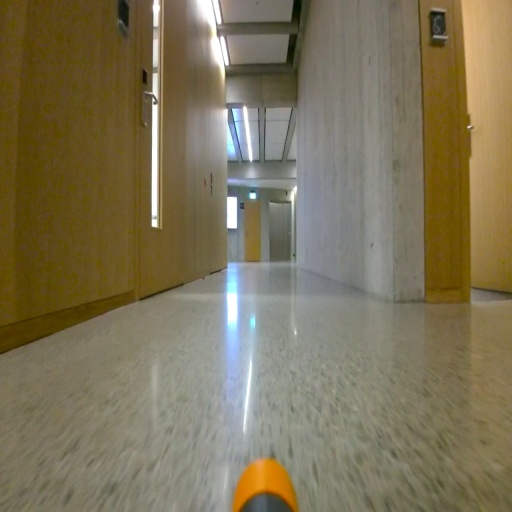

In [ ]:
img

In [ ]:
img = img.resize((64, 64))
img = np.array(img)

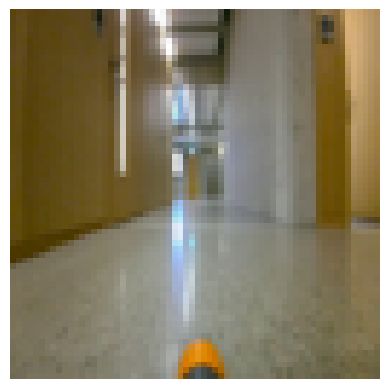

In [ ]:
image_array = img
plt.imshow(image_array.astype('uint8'))
plt.axis('off')
plt.show()


In [ ]:
img_array_reshaped = np.expand_dims(img, axis=0)

In [ ]:
test1 = encoder_model.predict(img_array_reshaped)

1/1 [==============================] - 0s 250ms/step


In [ ]:
test1_decode = decoder_model.predict(test1)

1/1 [==============================] - 0s 156ms/step


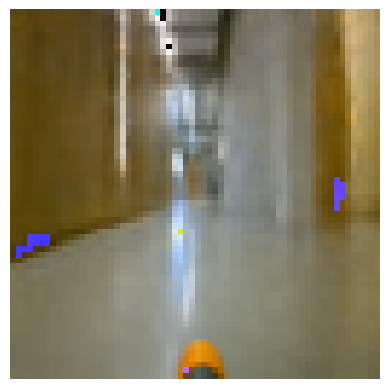

In [ ]:
image_array = test1_decode[0]
plt.imshow(image_array.astype('uint8'))
plt.axis('off')
plt.show()


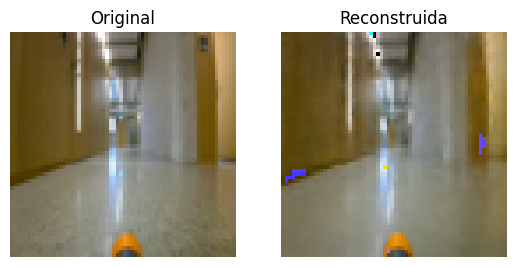

In [ ]:
image_array1 = img
image_array2 = test1_decode[0]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_array1.astype('uint8'))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(image_array2.astype('uint8'))
axes[1].axis('off')
axes[1].set_title('Reconstruida')
plt.show()

### Exameple 2

In [ ]:
img2 = Image.open('/content/s1_frames/outliers_set/000000_512_512.jpg')

In [ ]:
img2 = img2.resize((64, 64))
img2 = np.array(img2)

array([[[ 66,  53,   6],
        [ 66,  54,   5],
        [ 67,  54,   4],
        ...,
        [ 97,  99,  75],
        [ 95,  97,  76],
        [ 91,  93,  72]],

       [[ 66,  54,   3],
        [ 66,  54,   4],
        [ 66,  55,   4],
        ...,
        [ 97,  99,  79],
        [ 96,  97,  75],
        [ 89,  91,  69]],

       [[ 65,  56,   1],
        [ 65,  55,   1],
        [ 65,  54,   2],
        ...,
        [ 97,  99,  80],
        [ 93,  94,  75],
        [ 88,  89,  72]],

       ...,

       [[120, 119,  92],
        [123, 122,  94],
        [124, 122,  93],
        ...,
        [101, 102,  75],
        [104, 105,  74],
        [104, 104,  76]],

       [[121, 120,  91],
        [125, 124,  93],
        [124, 122,  93],
        ...,
        [ 97,  98,  70],
        [100, 101,  74],
        [103, 103,  75]],

       [[123, 120,  92],
        [124, 125,  94],
        [120, 121,  90],
        ...,
        [ 98, 100,  68],
        [106, 107,  78],
        [109, 107,  79]]], dtype=uint8)
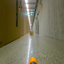

In [ ]:
img2

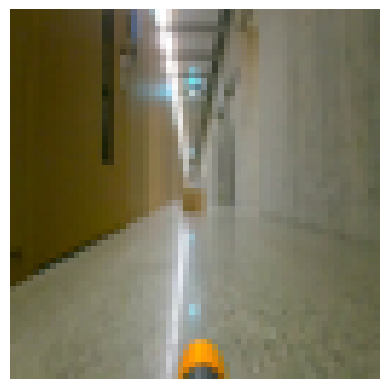

In [ ]:
image_array = img2
plt.imshow(image_array.astype('uint8'))
plt.axis('off')
plt.show()

In [ ]:
img_array_reshaped = np.expand_dims(img2, axis=0)

In [ ]:
test2 = encoder_model.predict(img_array_reshaped)

1/1 [==============================] - 0s 22ms/step


In [ ]:
test2_decode = decoder.predict(test2)

1/1 [==============================] - 0s 20ms/step


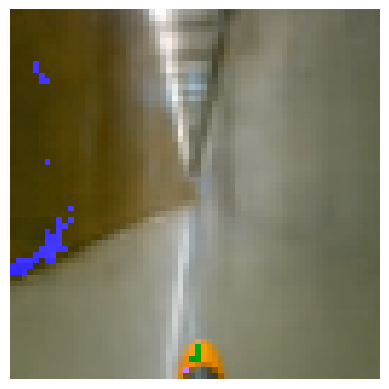

In [ ]:
image_array = test2_decode[0]
plt.imshow(image_array.astype('uint8'))
plt.axis('off')
plt.show()

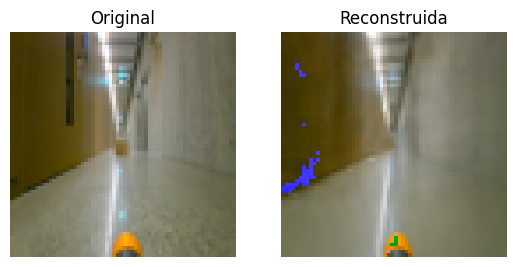

In [ ]:
image_array1 = img2
image_array2 = test2_decode[0]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_array1.astype('uint8'))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(image_array2.astype('uint8'))
axes[1].axis('off')
axes[1].set_title('Reconstruida')
plt.show()

## 2.3 ENCODING

### 2.3.1 Training_set_models

#### 2.3.1.1 Resize

In [ ]:
X_train_models=np.concatenate((X_train_models1,X_train_models2),axis=0)

#### 2.3.1.2 Encode

In [ ]:
images = X_train_models

encoder_model = autoencoder.get_layer('encoder')

batch_size = 32
encoded_images1 = []

for i in range(0, len(images), batch_size):
    batch_images1 = images[i:i+batch_size]
    encoded_imgs1 = encoder_model.predict(batch_images1)
    encoded_images1.append(encoded_imgs1)

encoded_images1 = np.concatenate(encoded_images1, axis=0)


print(encoded_images1.shape)

#### 2.3.1.3 Save encoding

In [ ]:
np.savetxt('training_set_models.txt', encoded_images1)

### 2.3.2 Test_set_models

#### 2.3.2.1 Resize

#### 2.3.2.2 Encode

In [ ]:
images = X_test_models


encoder_model = autoencoder.get_layer('encoder')

batch_size = 32
encoded_images2 = []

for i in range(0, len(images), batch_size):
    batch_images2 = images[i:i+batch_size]
    encoded_imgs2 = encoder_model.predict(batch_images2)
    encoded_images2.append(encoded_imgs2)

encoded_images2 = np.concatenate(encoded_images2, axis=0)

print(encoded_images2.shape)

1/1 [==============================] - 1s 698ms/step
(56100, 128)


#### 2.3.2.3 Save encoding

In [ ]:
#Las guarda para un futuro uso
np.save('encoded_images',encoded_images)

## 2.4 AUTOENCODER AS ANOMALLY DETECTOR

In [ ]:
ing =np.expand_dims(X_train_autoencoder[0], axis=0)
ing.shape

(1, 64, 64, 3)

In [ ]:
def mse_autoencoder_predict(image,path):
    img = Image.open(os.path.join(path, image))
    img = img.resize((64, 64))
    img = np.array(img)
    img_array_reshaped = np.expand_dims(img, axis=0)
    encoder_model = autoencoder.get_layer('encoder')
    decoder_model = autoencoder.get_layer('decoder')
    encoded_img = encoder_model.predict(img_array_reshaped)
    decoded_img = decoder_model.predict(encoded_img)
    mse = np.mean(np.square(img- decoded_img[0]))
    return mse


In [ ]:
test_models_folder_path = '/content/s1_frames/test_set'
training_models_folder_path = '/content/s1_frames/training_set'

In [ ]:
mse_autoencoder_predict('010775_512_512.jpg',test_models_folder_path)

1/1 [==============================] - 0s 20ms/step


232.28996

In [ ]:
mse_autoencoder_predict('000700_512_512.jpg',test_models_folder_path)

1/1 [==============================] - 0s 21ms/step


60.518055

In [ ]:
mse_autoencoder_predict('001000_512_512.jpg',training_models_folder_path)

1/1 [==============================] - 0s 20ms/step


41.164944

In [ ]:
mse_autoencoder_predict('000004_512_512.jpg',training_models_folder_path)

1/1 [==============================] - 0s 20ms/step


17.295656

In [ ]:
def classifier_AE(name_list,path):
  y_predict = []
  for i in range(len(name_list)):
    mse = mse_autoencoder_predict(name_list[i],path)
    print(mse)
    if mse >= 200:
      y_predict.append(1)
    else:
      y_predict.append(0)
    print(i)
  return y_predict

In [ ]:

def mse_autoencoder_predict(images, path, autoencoder):
    imgs = []
    for image in images:
        img = Image.open(os.path.join(path, image))
        img = img.resize((64, 64))
        img = np.array(img)
        imgs.append(img)

    imgs_array = np.array(imgs)
    encoder_model = autoencoder.get_layer('encoder')
    decoder_model = autoencoder.get_layer('decoder')
    encoded_imgs = encoder_model.predict(imgs_array)
    decoded_imgs = decoder_model.predict(encoded_imgs)

    mses = []
    for img, decoded_img in zip(imgs_array, decoded_imgs):
        img_flat = img.flatten()
        decoded_img_flat = decoded_img.flatten()
        mse = mean_squared_error(img_flat, decoded_img_flat)
        mses.append(mse)

    return mses

def classifier_AE(name_list, path, autoencoder, batch_size=32):
    y_predict = []
    for i in range(0, len(name_list), batch_size):
        batch_names = name_list[i:i+batch_size]
        mses = mse_autoencoder_predict(batch_names, path, autoencoder)
        print(batch_names)
        print(mses)
        for mse in mses:
            if mse >= 200:
                y_predict.append(1)
            else:
                y_predict.append(0)
        print(f'Processed batch {i//batch_size + 1}')
    return y_predict


In [ ]:
file_names = os.listdir('/content/s1_frames/test_set')


In [ ]:
y_predict = classifier_AE(file_names,test_models_folder_path,autoencoder,batch_size=32)

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 23ms/step
['011372_512_512.jpg', '015218_512_512.jpg', '005215_512_512.jpg', '037325_512_512.jpg', '031572_512_512.jpg', '047306_512_512.jpg', '023823_512_512.jpg', '038196_512_512.jpg', '025779_512_512.jpg', '033668_512_512.jpg', '036328_512_512.jpg', '055305_512_512.jpg', '014659_512_512.jpg', '010130_512_512.jpg', '049825_512_512.jpg', '025781_512_512.jpg', '052969_512_512.jpg', '001144_512_512.jpg', '029519_512_512.jpg', '008547_512_512.jpg', '023658_512_512.jpg', '039499_512_512.jpg', '013625_512_512.jpg', '041332_512_512.jpg', '039818_512_512.jpg', '012588_512_512.jpg', '007030_512_512.jpg', '011718_512_512.jpg', '025073_512_512.jpg', '027938_512_512.jpg', '038569_512_512.jpg', '025701_512_512.jpg']
[218.0003, 300.74384, 68.94996, 552.20856, 86.053246, 40.418842, 52.198536, 88.42883, 64.974205, 592.0948, 350.62317, 274.56473, 101.80737, 569.514, 28.421598, 64.92286, 326.8475, 17

In [ ]:
flist0=[]
list1=[]
for elem in y_predict:
  if elem ==0:
    list0.append(0)
  else:
    list1.append(1)
print(len(list0),len(list1))

38595 17505


In [ ]:
y_test = []

ruta_labels_test = '/content/metadata/test_frames_labels.csv'
data = pd.read_csv(ruta_labels_test, delimiter=',')
data2 = data['label'].to_list()
for e in data2:
  if e == 0:
    y_test.append(0)
  else:
    y_test.append(1)

In [ ]:
zeros = []
for e in y_test:
  if e == 1:
    zeros.append(e)
print(len(zeros))

9515


In [ ]:
anomalies = []
for i in range(len(y_test)):
  if y_test[i] ==1 :
    anomalies.append(i)

In [ ]:
test_models_folder_path

In [ ]:
predictions = []
for index in anomalies:
    image_path = file_names[index]
    print(image_path)
    prediction = mse_autoencoder_predict(image_path, test_models_folder_path)
    predictions.append((index, prediction))

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 27ms/step
033828_512_512.jpg
1/1 [==============================] - 0s 27ms/step
000585_512_512.jpg
1/1 [==============================] - 0s 26ms/step
015440_512_512.jpg
1/1 [==============================] - 0s 26ms/step
015702_512_512.jpg
1/1 [==============================] - 0s 25ms/step
037427_512_512.jpg
1/1 [==============================] - 0s 27ms/step
039892_512_512.jpg
1/1 [==============================] - 0s 27ms/step
003069_512_512.jpg
1/1 [==============================] - 0s 26ms/step
028490_512_512.jpg
1/1 [==============================] - 0s 26ms/step
029697_512_512.jpg
1/1 [==============================] - 0s 25ms/step
012806_512_512.jpg
1/1 [==============================] - 0s 27ms/step
042355_512_512.jpg
1/1 [==============================] - 0s 26ms/step
052387_512_512.jpg
1/1 [==============================] - 0s 26ms/step
027121_512_512.jpg
1/1 [===========

In [ ]:
predictions

[(0, 72.043816),
 (1, 61.43527),
 (2, 162.52202),
 (3, 110.71093),
 (4, 53.19695),
 (5, 202.05736),
 (6, 114.62554),
 (7, 291.51578),
 (8, 230.01672),
 (9, 394.5568),
 (10, 94.588745),
 (11, 54.739697),
 (12, 83.137375),
 (13, 49.162876),
 (14, 38.912296),
 (15, 934.6948),
 (16, 143.26979),
 (17, 196.29271),
 (18, 170.42989),
 (19, 16.933699),
 (20, 125.5928),
 (21, 83.934326),
 (22, 57.277054),
 (23, 58.139454),
 (24, 71.557556),
 (25, 647.4305),
 (26, 37.201633),
 (27, 55.554276),
 (28, 34.816364),
 (29, 21.307013),
 (30, 117.68984),
 (31, 90.81443),
 (32, 321.35287),
 (33, 635.4806),
 (34, 297.44583),
 (35, 88.680885),
 (36, 147.56078),
 (37, 73.680046),
 (38, 39.471764),
 (39, 40.08212),
 (40, 930.7255),
 (41, 22.296387),
 (42, 41.161144),
 (43, 80.32074),
 (44, 482.94424),
 (45, 66.58105),
 (46, 203.16669),
 (47, 37.07411),
 (48, 27.934713),
 (49, 233.66235),
 (50, 154.46382),
 (51, 163.65947),
 (52, 148.49702),
 (53, 284.4205),
 (54, 27.794235),
 (55, 105.578285),
 (56, 23.518265

In [ ]:
coincidences=[]

for elem1,elem2 in zip(y_test,y_predict):
  if elem1 ==elem2:
    coincidences.append(1)



In [ ]:
len(coincidences)/len(y_test) * 100

62.531194295900185

In [ ]:
auc = roc_auc_score(y_test, y_predict)
print("AUC:", auc)

AUC: 0.5015445071815396


# 3 LOAD DATA

In [ ]:
#Carga los datos desde un txt en el que tenemos guardado el vector para agilizar el proceso
X_train = np.loadtxt('/content/training_set_models.txt')
X_train = np.array(X_train)


In [ ]:
#Carga los datos desde un txt en el que tenemos guardado el vector para agilizar el proceso
X_test = np.loadtxt('/content/test_set_models.txt')
X_test = np.array(X_test)


In [ ]:
#Carga los labels del conjunto de entrenamiento del MLP
y_train = []

ruta_labels = '/content/drive/MyDrive/training_mixed_frames_labels.csv'
data = pd.read_csv(ruta_labels, delimiter=',')
data2 = data['label'].to_list()
for e in data2:
  if e == 0:
    y_train.append(0)
  else:
    y_train.append(1)

In [ ]:
#Carga los labels del conjunto de testeo del MLP
y_test = []

ruta_labels_test = '/content/metadata/test_frames_labels.csv'
data = pd.read_csv(ruta_labels_test, delimiter=',')
data2 = data['label'].to_list()
for e in data2:
  if e == 0:
    y_test.append(0)
  else:
    y_test.append(1)

In [ ]:
y_test = np.array(y_test)
y_train = np.array(y_train)

# 4. MLP

## 4.1 MODEL

In [ ]:
MLP = Sequential([
    Dense(256, input_shape=(128,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


opt = keras.optimizers.Adam(learning_rate=0.0001)
MLP.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
MLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49537 (193.50 KB)
Trainable params: 49537 (193.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4.1 TRAINING

In [ ]:
#Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
X_train_MLP = np.array(X_train_MLP)
y_train = np.array(y_train)


In [ ]:
MLP.fit(X_train_MLP, y_train, batch_size=32, epochs=50, validation_split=0.2,callbacks=[early_stopping])


Epoch 1/50
1857/1857 [==============================] - 9s 3ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.8311e-06 - val_accuracy: 1.0000
Epoch 2/50
1857/1857 [==============================] - 6s 3ms/step - loss: 4.5069e-10 - accuracy: 1.0000 - val_loss: 1.7973e-06 - val_accuracy: 1.0000
Epoch 3/50
1857/1857 [==============================] - 6s 3ms/step - loss: 4.2284e-10 - accuracy: 1.0000 - val_loss: 1.7491e-06 - val_accuracy: 1.0000
Epoch 4/50
1857/1857 [==============================] - 6s 3ms/step - loss: 3.7913e-10 - accuracy: 1.0000 - val_loss: 1.6750e-06 - val_accuracy: 1.0000
Epoch 5/50
1857/1857 [==============================] - 6s 3ms/step - loss: 3.0884e-10 - accuracy: 1.0000 - val_loss: 1.5493e-06 - val_accuracy: 1.0000
Epoch 6/50
1857/1857 [==============================] - 6s 3ms/step - loss: 2.1306e-10 - accuracy: 1.0000 - val_loss: 1.3800e-06 - val_accuracy: 1.0000
Epoch 7/50
1857/1857 [==============================] - 6s 3ms/step - loss: 1.1934e-10 - acc

### Save model

In [ ]:
MLP.save('/content/MLP')

In [ ]:
folder_to_zip = '/content/MLP'

zip_filename = 'autoencoder.zip'

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_to_zip))

from google.colab import files
files.download(zip_filename)

### Load model

In [ ]:
ruta_MLP = "/content/drive/MyDrive/MLP.zip"

In [ ]:
with zipfile.ZipFile(ruta_MLP, 'r') as zip_ref:
    zip_ref.extractall('MLP')

## Test

In [ ]:
predictions = MLP.predict(X_test)


1754/1754 [==============================] - 3s 2ms/step


In [ ]:
predictions
y_predict=[]
for e in predictions:
  if e > 0.5:
    y_predict.append(1)
  else:
    y_predict.append(0)
y_predict = np.array(y_predict)


In [ ]:
np.savetxt('predict',y_predict)

In [ ]:
auc = roc_auc_score(y_test, predictions)

print("AUC:", auc)

AUC: 0.5000930973848029
